In [1]:
# ─── Cell 1: Install any missing dependencies ─────────────────────────────────
%pip install torch torchvision wandb tqdm matplotlib scikit-learn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.6 MB/s eta 0:00:00


In [2]:
import wandb
wandb.login(key="9699f0f4bdfee5d846108d559a41e2049bdebc43")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muditgupta2502 (muditgupta2502-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
!pip install gdown


In [4]:
!gdown --id 1d1WeW0Y1xMehsVuHg_fQaM2xA5W9eXMC


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1d1WeW0Y1xMehsVuHg_fQaM2xA5W9eXMC
To: /content/your_face.zip
100% 24.5M/24.5M [00:00<00:00, 36.7MB/s]


In [5]:
!unzip -o your_face.zip -d data


Archive:  your_face.zip
   creating: data/your_face/
   creating: data/your_face/augmented/
   creating: data/your_face/augmented/bright_light/
   creating: data/your_face/augmented/bright_light/angry/
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0000.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0001.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0002.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0003.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0004.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0005.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0006.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0007.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0008.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0009.jpg 

In [6]:
# ─── Cell 2: Imports & Configuration ────────────────────────────────────────
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torchvision.models import (
    vgg16, VGG16_Weights,
    resnet18, ResNet18_Weights
)
from torchvision.datasets.folder import default_loader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import wandb

# Paths & hyperparameters
DATA_ROOT    = 'data/your_face'       # contains raw/ and augmented/
EMOTIONS     = ['angry','happy','sad'] # updated emotion classes
NUM_CLASSES  = len(EMOTIONS)
BATCH_SIZE   = 32
IMG_SIZE     = 224
NUM_EPOCHS   = 8
LR           = 1e-4
DEVICE       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAMES  = ['vgg16_emotion','r18_scratch_emotion','r18_pre_emotion']


In [7]:
# ─── Cell 3: Initialize W&B ──────────────────────────────────────────────────
wandb.init(
    project='emotion-recognition',
    config=dict(
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        num_epochs=NUM_EPOCHS,
        lr=LR,
        models=MODEL_NAMES,
        emotions=EMOTIONS,
        split='60/20/20'
    ),
    mode='online'
)
cfg = wandb.config


In [8]:
# ─── Cell 4: Data Transforms ─────────────────────────────────────────────────
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.4,0.4,0.4,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.1)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


In [9]:
# ─── Cell 5: Custom EmotionDataset ──────────────────────────────────────────
class EmotionDataset(Dataset):
    def __init__(self, root, emotions, transform=None):
        self.samples = []
        self.transform = transform
        e_map = {e.lower(): i for i,e in enumerate(emotions)}
        for split in ['raw','augmented']:
            split_dir = os.path.join(root, split)
            if not os.path.isdir(split_dir): continue
            for cond in os.listdir(split_dir):
                cond_dir = os.path.join(split_dir, cond)
                if not os.path.isdir(cond_dir): continue
                for emo in os.listdir(cond_dir):
                    idx = e_map.get(emo.lower(), None)
                    if idx is None: continue
                    emo_dir = os.path.join(cond_dir, emo)
                    for fname in os.listdir(emo_dir):
                        if fname.lower().endswith(('.jpg','.jpeg','.png')):
                            path = os.path.join(emo_dir, fname)
                            self.samples.append((path, idx))
        print(f"Found {len(self.samples)} emotion‐labeled images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = default_loader(path)
        if self.transform:
            img = self.transform(img)
        return img, label

# build full dataset
full_ds = EmotionDataset(DATA_ROOT, EMOTIONS, transform=train_tf)
n_total = len(full_ds)


Found 2160 emotion‐labeled images


In [10]:
# ─── Cell 6: Split & DataLoaders ────────────────────────────────────────────
# 60% train / 20% val / 20% test
n_train = int(0.6 * n_total)
n_val   = int(0.2 * n_total)
n_test  = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    full_ds,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)
# swap in val transforms
val_ds.dataset.transform  = val_tf
test_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Split sizes: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")


Split sizes: Train=1296, Val=432, Test=432


In [11]:
# ─── Cell 7: Model Factory ──────────────────────────────────────────────────
def get_emotion_model(name):
    if name=='vgg16_emotion':
        m = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        for p in m.features.parameters(): p.requires_grad=False
        m.classifier = nn.Sequential(
            nn.Linear(25088,512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, NUM_CLASSES)
        )
    elif name=='r18_scratch_emotion':
        m = resnet18(weights=None)
        m.fc = nn.Linear(m.fc.in_features, NUM_CLASSES)
    elif name=='r18_pre_emotion':
        m = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, NUM_CLASSES)
    else:
        raise ValueError(name)
    return m.to(DEVICE)


In [12]:
# ─── Cell 8: Training & Validation Helpers ─────────────────────────────────
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, optimizer):
    model.train()
    total_loss, preds, targets = 0.0, [], []
    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*x.size(0)
        preds   += out.argmax(1).cpu().tolist()
        targets += y.cpu().tolist()
    return total_loss/len(train_ds), accuracy_score(targets,preds)

def validate(model, loader):
    model.eval()
    total_loss, preds, targets = 0.0, [], []
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out  = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()*x.size(0)
            preds   += out.argmax(1).cpu().tolist()
            targets += y.cpu().tolist()
    return total_loss/len(loader.dataset), accuracy_score(targets,preds)


In [13]:
# ─── Cell 9: Train Three Emotion Models ─────────────────────────────────────
history = {}
for name in MODEL_NAMES:
    wandb.run.name = name
    model = get_emotion_model(name)
    wandb.watch(model, log='all')
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    history[name] = {'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    best_val = 0.0

    for ep in range(NUM_EPOCHS):
        tr_l, tr_a = train_one_epoch(model, optimizer)
        val_l, val_a = validate(model, val_loader)
        scheduler.step()

        history[name]['train_loss'].append(tr_l)
        history[name]['train_acc'].append(tr_a)
        history[name]['val_loss'].append(val_l)
        history[name]['val_acc'].append(val_a)

        wandb.log({
            f"{name}/train_loss": tr_l,
            f"{name}/train_acc":  tr_a,
            f"{name}/val_loss":   val_l,
            f"{name}/val_acc":    val_a,
            'epoch': ep+1
        })
        if val_a>best_val:
            best_val=val_a
            torch.save(model.state_dict(), f"{name}_best.pth")
        print(f"[{name}] Epoch {ep+1}/{NUM_EPOCHS}  tr={tr_a:.3f} val={val_a:.3f}")

    print(f"✔ {name} best val_acc = {best_val:.3f}\n")
wandb.finish()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 149MB/s]


[vgg16_emotion] Epoch 1/8  tr=0.632 val=0.875
[vgg16_emotion] Epoch 2/8  tr=0.924 val=0.910
[vgg16_emotion] Epoch 3/8  tr=0.971 val=0.954
[vgg16_emotion] Epoch 4/8  tr=0.994 val=0.954
[vgg16_emotion] Epoch 5/8  tr=0.999 val=0.951
[vgg16_emotion] Epoch 6/8  tr=0.998 val=0.963
[vgg16_emotion] Epoch 7/8  tr=0.999 val=0.963
[vgg16_emotion] Epoch 8/8  tr=1.000 val=0.963
✔ vgg16_emotion best val_acc = 0.963

[r18_scratch_emotion] Epoch 1/8  tr=0.479 val=0.646
[r18_scratch_emotion] Epoch 2/8  tr=0.718 val=0.493
[r18_scratch_emotion] Epoch 3/8  tr=0.837 val=0.727
[r18_scratch_emotion] Epoch 4/8  tr=0.958 val=0.801
[r18_scratch_emotion] Epoch 5/8  tr=0.992 val=0.845
[r18_scratch_emotion] Epoch 6/8  tr=0.995 val=0.808
[r18_scratch_emotion] Epoch 7/8  tr=1.000 val=0.845
[r18_scratch_emotion] Epoch 8/8  tr=1.000 val=0.836
✔ r18_scratch_emotion best val_acc = 0.845



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


[r18_pre_emotion] Epoch 1/8  tr=0.791 val=0.958
[r18_pre_emotion] Epoch 2/8  tr=0.990 val=0.984
[r18_pre_emotion] Epoch 3/8  tr=0.996 val=0.975
[r18_pre_emotion] Epoch 4/8  tr=0.999 val=0.988
[r18_pre_emotion] Epoch 5/8  tr=1.000 val=0.991
[r18_pre_emotion] Epoch 6/8  tr=1.000 val=0.991
[r18_pre_emotion] Epoch 7/8  tr=1.000 val=0.991
[r18_pre_emotion] Epoch 8/8  tr=1.000 val=0.988
✔ r18_pre_emotion best val_acc = 0.991



epoch,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
r18_pre_emotion/train_acc,▁███████
r18_pre_emotion/train_loss,█▂▁▁▁▁▁▁
r18_pre_emotion/val_acc,▁▇▅█████
r18_pre_emotion/val_loss,█▃▄▂▂▁▁▁
r18_scratch_emotion/train_acc,▁▄▆▇████
r18_scratch_emotion/train_loss,█▆▄▂▁▁▁▁
r18_scratch_emotion/val_acc,▄▁▆▇█▇██
r18_scratch_emotion/val_loss,▃█▃▁▁▁▁▁
vgg16_emotion/train_acc,▁▇▇█████
vgg16_emotion/train_loss,█▃▂▁▁▁▁▁



=== vgg16_emotion ===
              precision    recall  f1-score   support

       angry     0.9799    0.9542    0.9669       153
       happy     0.9857    0.9517    0.9684       145
         sad     0.9301    0.9925    0.9603       134

    accuracy                         0.9653       432
   macro avg     0.9652    0.9662    0.9652       432
weighted avg     0.9664    0.9653    0.9654       432



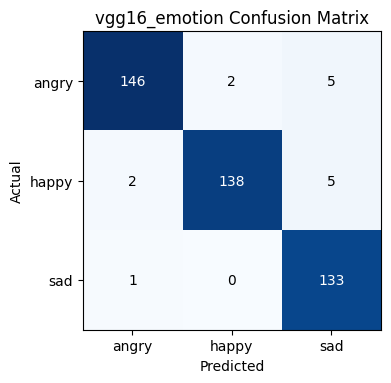


=== r18_scratch_emotion ===
              precision    recall  f1-score   support

       angry     0.9120    0.7451    0.8201       153
       happy     0.8406    0.8000    0.8198       145
         sad     0.7041    0.8881    0.7855       134

    accuracy                         0.8079       432
   macro avg     0.8189    0.8111    0.8085       432
weighted avg     0.8236    0.8079    0.8093       432



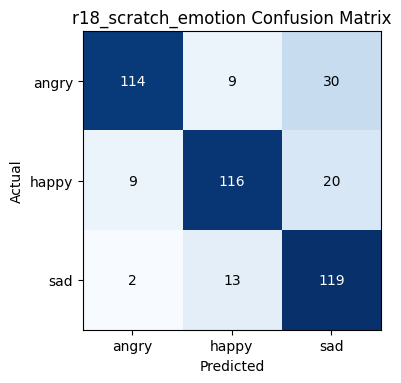


=== r18_pre_emotion ===
              precision    recall  f1-score   support

       angry     0.9868    0.9804    0.9836       153
       happy     0.9931    0.9931    0.9931       145
         sad     0.9778    0.9851    0.9814       134

    accuracy                         0.9861       432
   macro avg     0.9859    0.9862    0.9860       432
weighted avg     0.9861    0.9861    0.9861       432



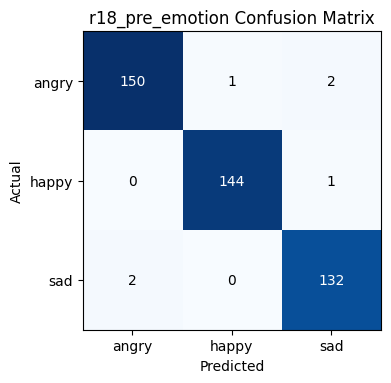

In [14]:
# ─── Cell 10: Evaluation & Confusion Matrices ───────────────────────────────
for name in MODEL_NAMES:
    print(f"\n=== {name} ===")
    m = get_emotion_model(name)
    m.load_state_dict(torch.load(f"{name}_best.pth"))
    m.eval()

    all_p, all_t = [], []
    with torch.no_grad():
        for x,y in test_loader:
            x = x.to(DEVICE)
            out = m(x)
            all_p.extend(out.argmax(1).cpu().tolist())
            all_t.extend(y.cpu().tolist())

    labels = list(range(NUM_CLASSES))
    print(classification_report(
        all_t, all_p,
        labels=labels,
        target_names=EMOTIONS,
        digits=4,
        zero_division=0
    ))

    cm = confusion_matrix(all_t, all_p, labels=labels)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(labels); ax.set_yticks(labels)
    ax.set_xticklabels(EMOTIONS); ax.set_yticklabels(EMOTIONS)
    for i in labels:
        for j in labels:
            ax.text(j,i, cm[i,j],
                    ha='center', va='center',
                    color='white' if cm[i,j]>cm.max()/2 else 'black')
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    ax.set_title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


image_idx,▁▃▁▁█
image_idx,2073
predicted_emotion_vgg16,happy
true_label,happy


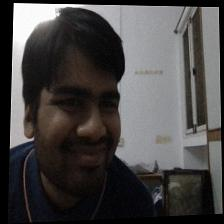

Predicted: SAD → 😔 Feeling sad? Hope this calming melody helps:



--------------------------------------------------



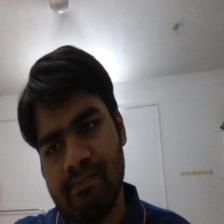

Predicted: ANGRY → 😠 You seem angry. Take a breath and listen to this soothing track:



--------------------------------------------------



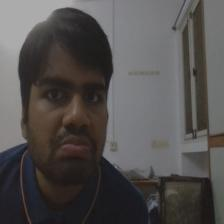

Predicted: SAD → 😔 Feeling sad? Hope this calming melody helps:



--------------------------------------------------



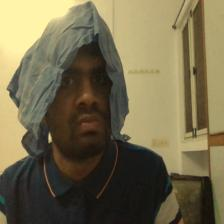

Predicted: ANGRY → 😠 You seem angry. Take a breath and listen to this soothing track:



--------------------------------------------------



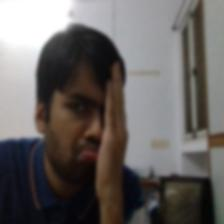

Predicted: ANGRY → 😠 You seem angry. Take a breath and listen to this soothing track:



--------------------------------------------------



image_idx,▆▃▅▁█
image_idx,1849
predicted_emotion_vgg16,angry
true_label,sad


In [22]:
# ─── Cell: Creative Element & Optional Test Video Generation for Detected Emotions ────
import os
import wandb
from IPython.display import display, HTML, Image, Video
import random
import torch
import cv2
from torchvision.transforms import ToPILImage

# Initialize a new W&B run
wandb.login()
wandb.init(
    project='emotion-recognition',
    name='Creative_Element_and_Video_Test',
    config={
        'models': MODEL_NAMES,
        'emotions': EMOTIONS,
        'split': 'Test'
    }
)

# 1) Creative Element: Random Test Images
reactions = {
    'happy': {
        'text': "😊 You look happy! Here's a cheerful tune to match your mood:",
        'audio': "https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3"
    },
    'sad': {
        'text': "😔 Feeling sad? Hope this calming melody helps:",
        'audio': "https://www.soundhelix.com/examples/mp3/SoundHelix-Song-3.mp3"
    },
    'angry': {
        'text': "😠 You seem angry. Take a breath and listen to this soothing track:",
        'audio': "https://www.soundhelix.com/examples/mp3/SoundHelix-Song-7.mp3"
    }
}

samples = random.sample(test_ds.indices, min(5, len(test_ds)))
for idx in samples:
    img_path, true_label = full_ds.samples[idx]
    display(Image(filename=img_path, width=200, height=200))

    tensor = val_tf(default_loader(img_path)).unsqueeze(0).to(DEVICE)
    preds  = get_emotion_model('vgg16_emotion')(tensor)
    pred   = EMOTIONS[preds.argmax(1).item()]

    wandb.log({
        'image_idx': idx,
        'true_label': EMOTIONS[true_label],
        'predicted_emotion_vgg16': pred,
        'image': wandb.Image(img_path, caption=f"True: {EMOTIONS[true_label]}, Pred: {pred}")
    })

    react = reactions[pred]
    print(f"Predicted: {pred.upper()} → {react['text']}")
    display(HTML(f"""
        <audio controls>
          <source src="{react['audio']}" type="audio/mpeg">
          Your browser does not support the audio element.
        </audio>
    """))
    print("\n" + "-"*50 + "\n")

# 2) Optional Test Video Generation for All Models
input_video = 'test_video.mp4'
if not os.path.exists(input_video):
    print(f"Warning: Input video '{input_video}' not found; skipping video generation and logging.")
else:
    # Load models
    model_paths = {name: f"{name}_best.pth" for name in MODEL_NAMES}
    models = {}
    for name in MODEL_NAMES:
        ckpt = model_paths[name]
        if not os.path.exists(ckpt):
            print(f"Warning: Checkpoint '{ckpt}' not found; skipping '{name}'.")
            continue
        m = get_emotion_model(name)
        m.load_state_dict(torch.load(ckpt, map_location=DEVICE))
        m.to(DEVICE).eval()
        models[name] = m

    # Capture setup
    cap = cv2.VideoCapture(input_video)
    if not cap.isOpened():
        print(f"Warning: Could not open '{input_video}'; skipping.")
    else:
        fps    = cap.get(cv2.CAP_PROP_FPS) or 10
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        to_pil = ToPILImage()
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')

        writers = {}
        for name in models:
            out_fn = f"{name}_test_video.mp4"
            w = cv2.VideoWriter(out_fn, fourcc, fps, (width, height))
            if not w.isOpened():
                print(f"Warning: Cannot write '{out_fn}'; skipping.")
                continue
            writers[name] = w

        # Frame processing
        while True:
            ret, frame = cap.read()
            if not ret: break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil = to_pil(torch.from_numpy(rgb).permute(2,0,1))
            inp = val_tf(pil).unsqueeze(0).to(DEVICE)
            for name, m in models.items():
                if name not in writers: continue
                with torch.no_grad(): out = m(inp)
                label = EMOTIONS[out.argmax(1).item()]
                a = frame.copy()
                cv2.putText(a, f"{name}: {label.upper()}", (10,30), cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
                writers[name].write(a)

        cap.release()
        for w in writers.values(): w.release()

        # Log & display
        for name in writers:
            file = f"{name}_test_video.mp4"
            if os.path.exists(file):
                print(f"Logging {file} to W&B")
                wandb.log({name+'_test_video': wandb.Video(file, caption=name, fps=fps, format='mp4')})
                display(Video(file, embed=True))
            else:
                print(f"Warning: Generated '{file}' not found.")

# Finish run
wandb.finish()
